In [16]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
# load local version of gallifrey, before pip installed version, for debugging
import pathlib
import sys
import os

sys.path.append(str(pathlib.Path(os.getcwd()).parent.joinpath("src")))

In [18]:
import yt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from gallifrey.model import Model
from gallifrey.utilities.math import calculate_pca
from gallifrey.utilities.dataframe import (
    aggregated_dataframe,
    rename_labels,
    rename_entries,
)
from gallifrey.visualization.visualization_utils import (
    set_plot_defaults,
    get_palette,
    FigureProcessor,
    ridgeplot,
)

## DATA SETUP

In [25]:
snapshot = 127
resolution = 8192
sim_id = "37_11"

In [26]:
model = Model(
    snapshot=snapshot,
    resolution=resolution,
    sim_id=sim_id,
)
ds = model.ds
mw = model.halo

yt : [INFO     ] 2023-11-08 12:32:17,930 Calculating time from 1.000e+00 to be 4.318e+17 seconds
yt : [INFO     ] 2023-11-08 12:32:18,197 Parameters: current_time              = 4.318436660023809e+17 s
yt : [INFO     ] 2023-11-08 12:32:18,198 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2023-11-08 12:32:18,199 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-11-08 12:32:18,200 Parameters: domain_right_edge         = [100. 100. 100.]
yt : [INFO     ] 2023-11-08 12:32:18,202 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-11-08 12:32:18,202 Parameters: current_redshift          = 4.440892098500626e-16
yt : [INFO     ] 2023-11-08 12:32:18,203 Parameters: omega_lambda              = 0.682
yt : [INFO     ] 2023-11-08 12:32:18,204 Parameters: omega_matter              = 0.318
yt : [INFO     ] 2023-11-08 12:32:18,205 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-11-08 12:32:18,206 Parameters: hubble_constant      

## PLOT SETUP

In [ ]:
set_plot_defaults()

figure_subdirectory = f"MilkyWayAnalogue/{model.resolution}/{model.sim_id}/{model.snapshot}/Galaxy_components"
save = True

## CREATE DATA SOURCE

In [ ]:
radius = 0.2 * mw.virial_radius()
sphere_data = mw.sphere(radius=radius)

In [ ]:
components = ["bulge_stars", "thin_disk_stars", "thick_disk_stars", "halo_stars"]
data = aggregated_dataframe(
    components,
    [
        "[Fe/H]",
        "stellar_age",
        "Masses",
    ],
    data_source=sphere_data,
    type_name="Component",
    custom_units={"stellar_age": "Gyr"},
)

# filtering values
filters = {"[Fe/H]": (-2.5, 1)}
for field_value, ranges in filters.items():
    data = data[data[field_value].between(*ranges)]

# rename labels and components
data = rename_entries(data)
data, labels = rename_labels(data)

## FRACTION OF MASS IN COMPONENTS

In [ ]:
data.groupby("Component")["Masses"].sum()

Component
Bulge         1.575101e+10
Halo          4.317865e+09
Thick Disk    3.488819e+09
Thin Disk     3.490806e+10
Name: Masses, dtype: float64

In [15]:
data.groupby("Component")["Masses"].sum() / data["Masses"].sum()

Component
Bulge         0.125397
Halo          0.073853
Thick Disk    0.203681
Thin Disk     0.597069
Name: Masses, dtype: float64

## STELLAR AGE IN COMPONENTS

In [38]:
data.groupby("Component")[labels["stellar_age"]].describe().T

Component,Bulge,Halo,Thick Disk,Thin Disk
count,201924.000000,318490.000000,527910.000000,1.497948e+06
mean,8.428806,9.833251,8.282258,5.994123e+00
std,2.676052,2.012835,2.248866,2.434521e+00
min,0.021317,0.025214,0.023111,2.001893e-02
25%,6.766305,8.862184,6.877006,4.639016e+00
50%,8.754735,10.093815,8.545390,6.087537e+00
75%,10.528148,11.318921,9.817189,7.580312e+00
max,13.484454,13.484454,13.509129,1.346309e+01


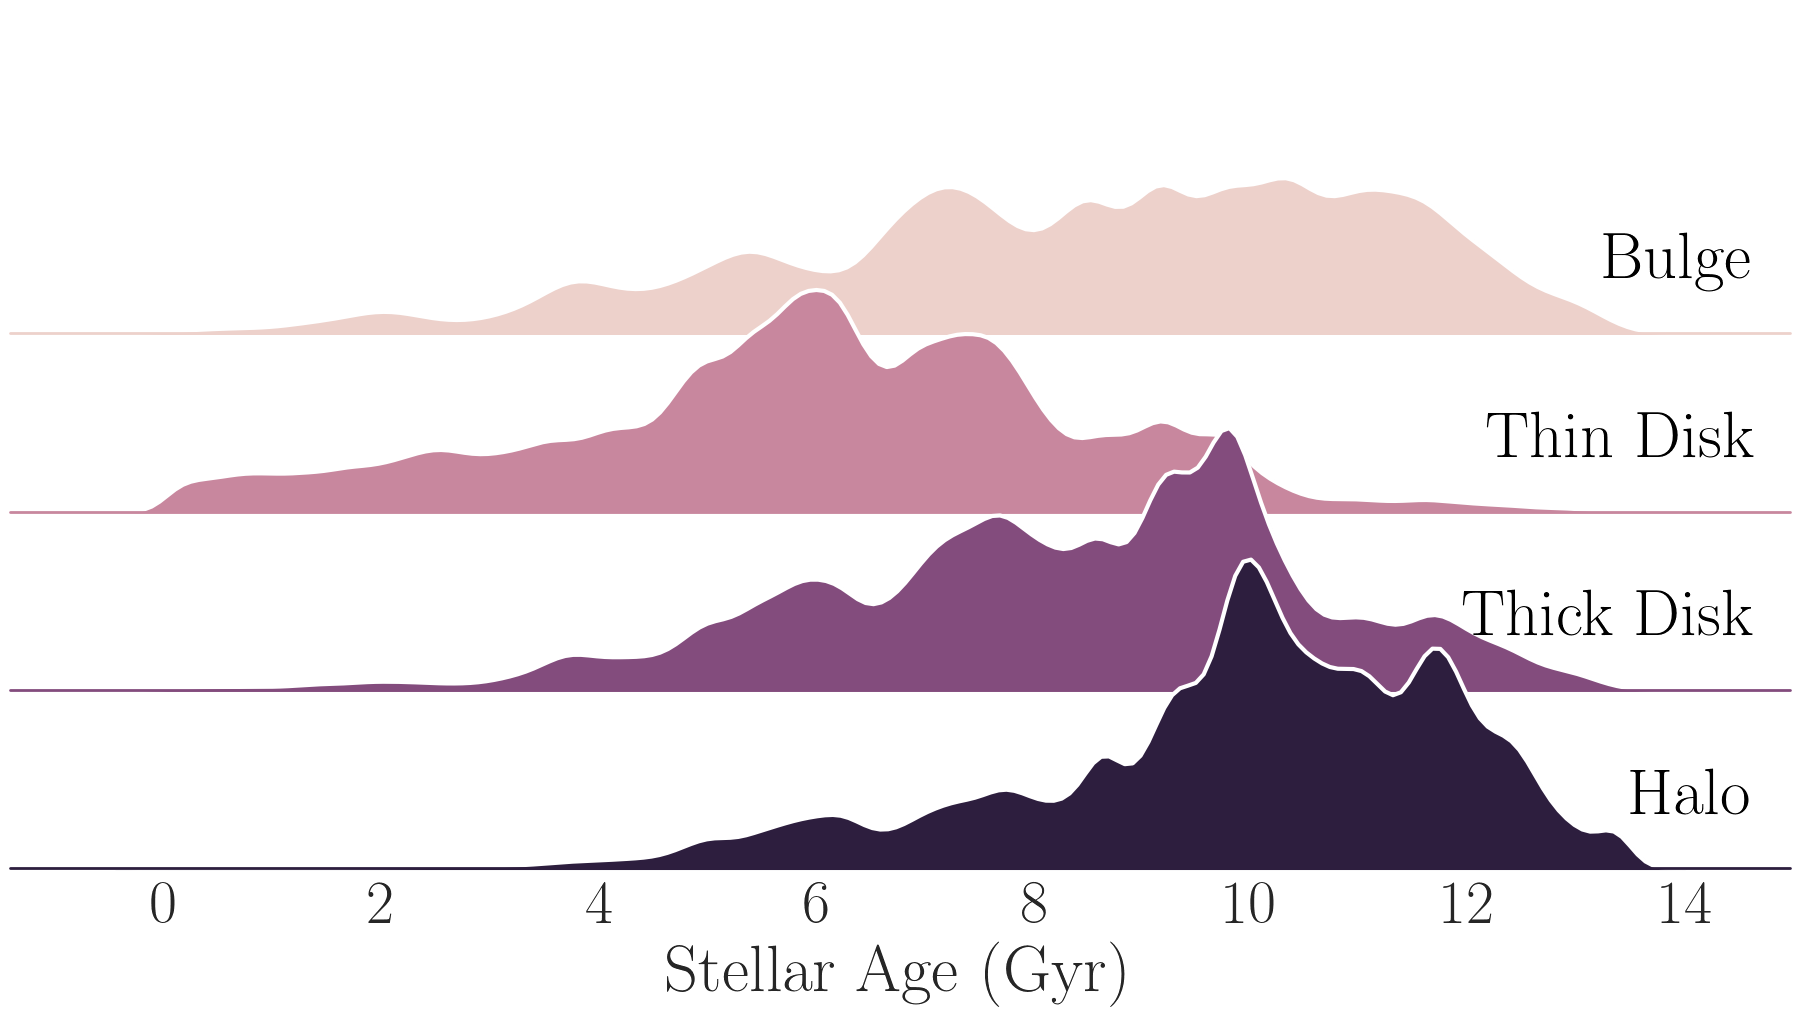

In [39]:
ridgeplot_age = ridgeplot(
    data,
    x=labels["stellar_age"],
    row="Component",
    palette=get_palette(n_colors=4),
    label_position=[0.98, 0.22],
)
FigureProcessor(ridgeplot_age.figure).save(
    "ridgeplot_age.pdf",
    sub_directory=figure_subdirectory,
    save=save,
)

## METALLICITY IN COMPONENTS

In [40]:
data.groupby("Component")["[Fe/H]"].describe().T

Component,Bulge,Halo,Thick Disk,Thin Disk
count,201924.000000,318490.000000,527910.000000,1.497948e+06
mean,0.173661,-0.585297,-0.177395,1.470608e-02
std,0.436530,0.469004,0.475729,3.248903e-01
min,-2.497954,-2.499774,-2.497884,-2.499517e+00
25%,-0.120150,-0.819855,-0.472752,-1.877237e-01
50%,0.240451,-0.559543,-0.225276,1.595969e-02
75%,0.519589,-0.319978,0.158464,2.380800e-01
max,0.999516,0.919996,0.999591,9.994379e-01


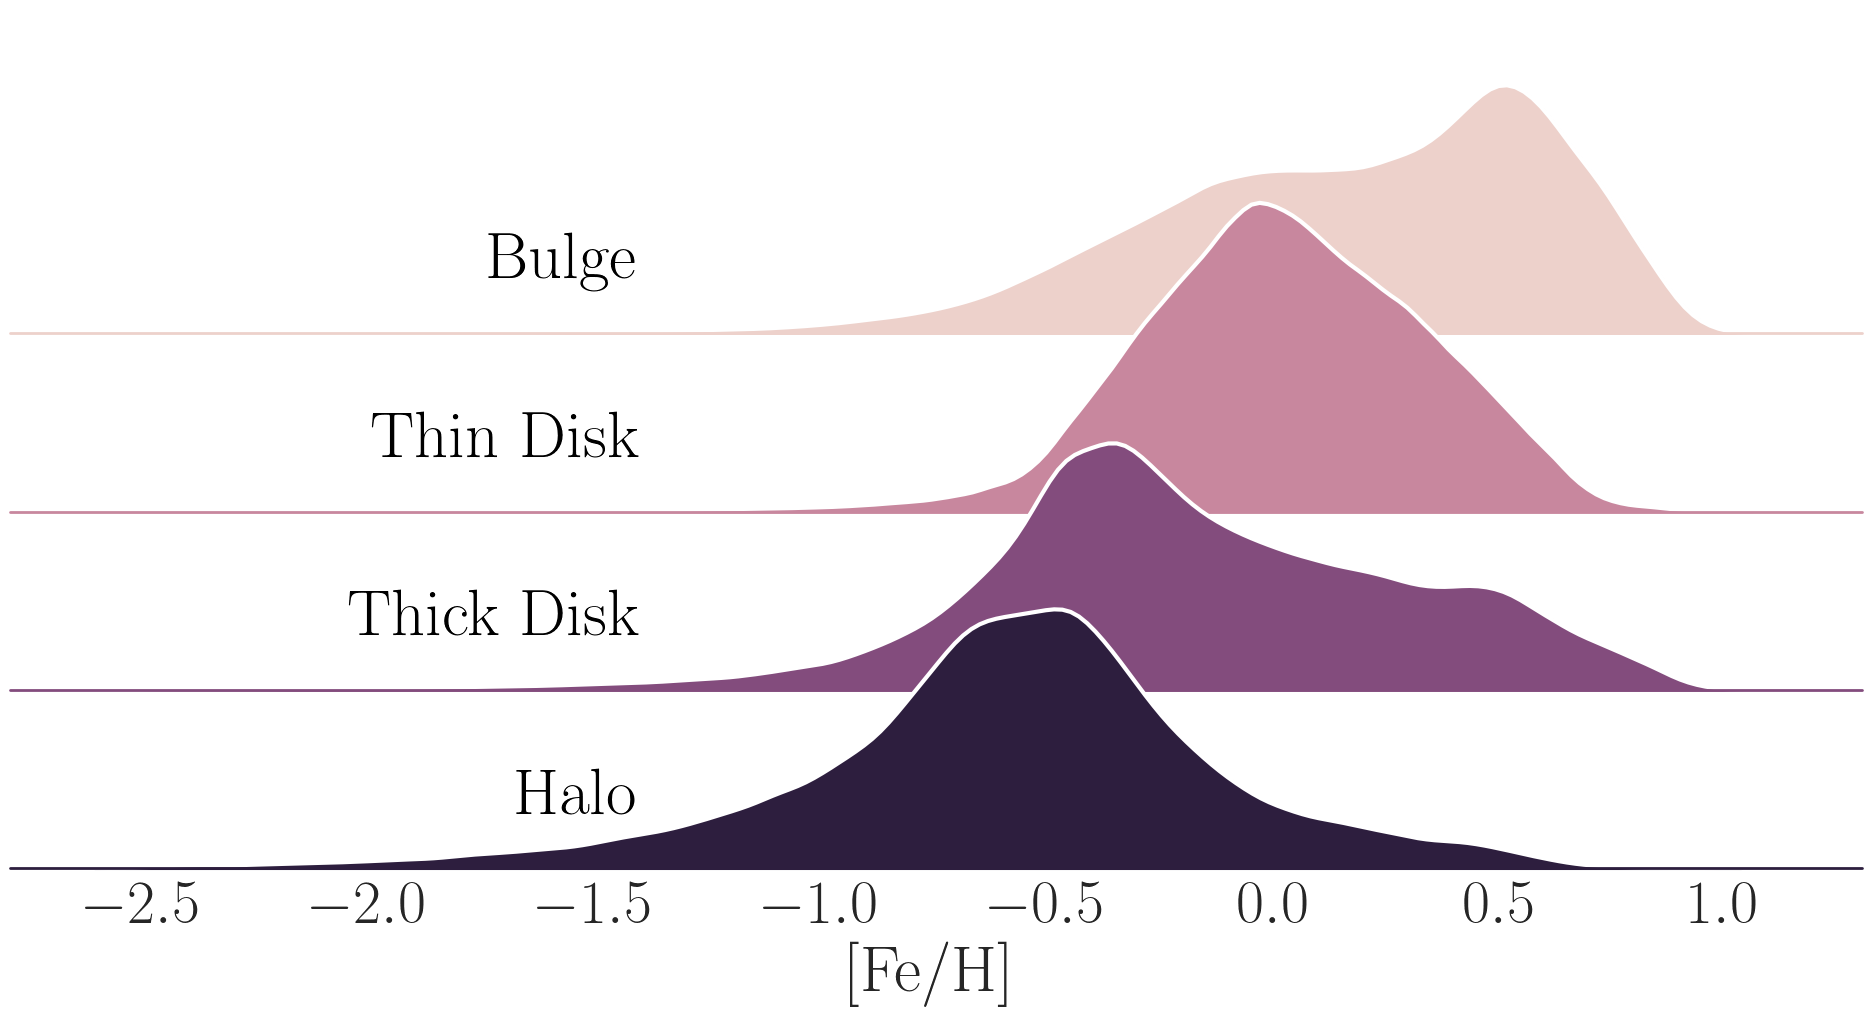

In [41]:
ridgeplot_metallicity = ridgeplot(
    data,
    x=labels["[Fe/H]"],
    row="Component",
    palette=get_palette(n_colors=4),
    label_position=[0.34, 0.22],
)
FigureProcessor(ridgeplot_metallicity.figure).save(
    "ridgeplot_metallicity.pdf",
    sub_directory=figure_subdirectory,
    save=save,
)

## PRICIPAL COMPONENTS

In [42]:
variance_ratios = pd.DataFrame(
    np.array(
        [
            calculate_pca(
                sphere_data[component, "particle_position"].to("kpc")
            ).explained_variance_ratio_
            for component in components
        ]
    ).T,
    columns=components,
).T

print("Minor-to-major axis ratio:")
print(variance_ratios[2] / variance_ratios[0])

Minor-to-major axis ratio:
bulge_stars         0.246304
thin_disk_stars     0.058113
thick_disk_stars    0.388147
halo_stars          0.628607
dtype: float64
